In [1]:
import torch
import wandb
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%config InlineBackend.figure_format = 'retina'

/Users/konansul/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307, ), (0.3081, )),
])

In [3]:
mnist_train = torchvision.datasets.MNIST('./mnist/', train = True, download = True, transform = transform)
mnist_val = torchvision.datasets.MNIST('./mnist/', train = False, download = True, transform = transform)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size = 40, shuffle = True, num_workers = 1)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size = 40, shuffle = False, num_workers = 1)

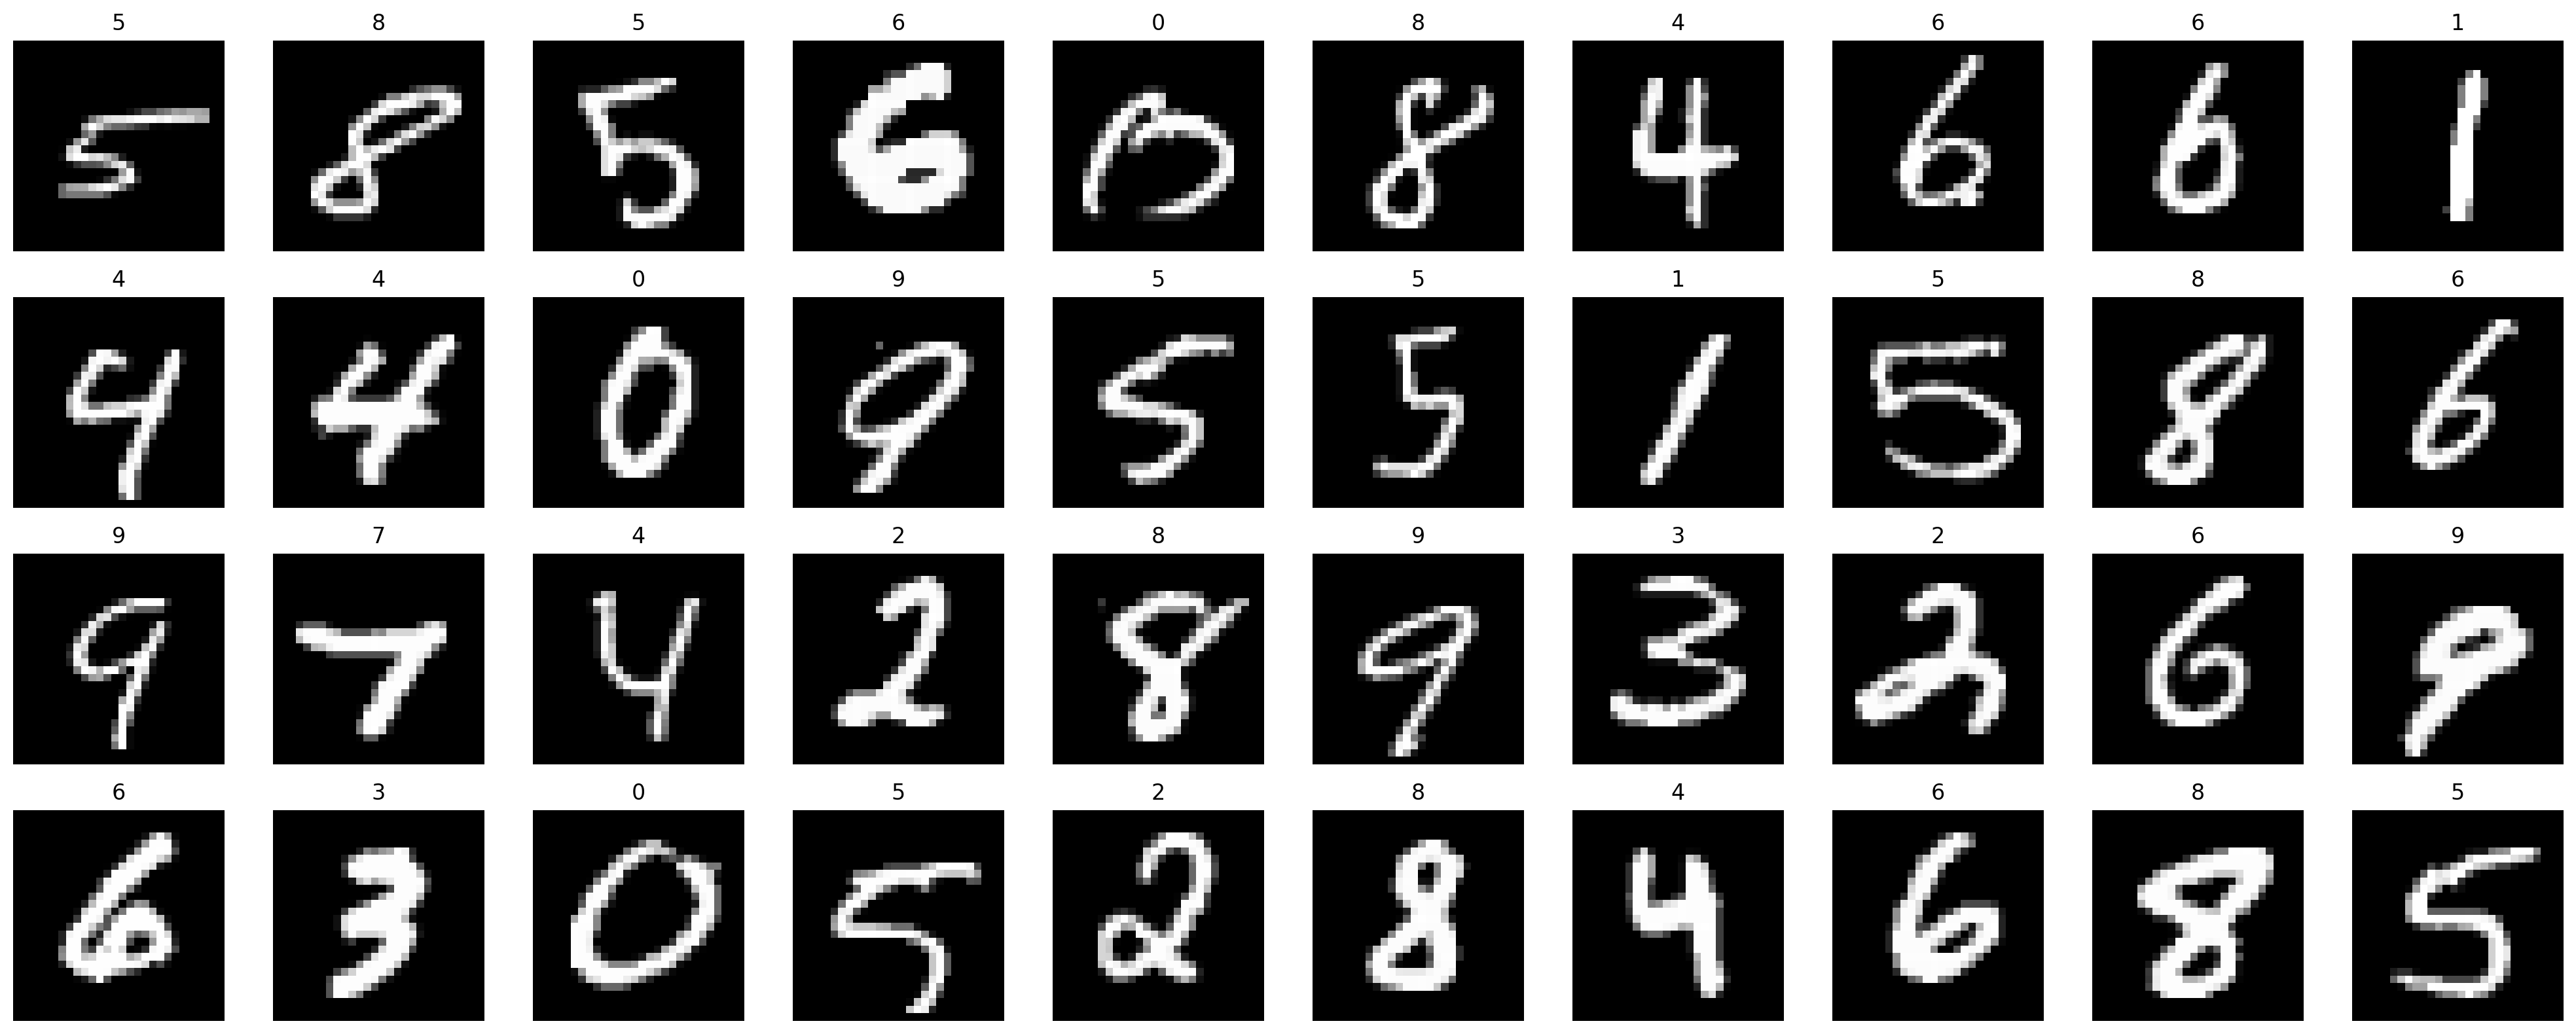

In [4]:
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(4, 10, figsize = (20, 8))  

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap = 'gray') 
    ax.set_title(labels[i].item())
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [7]:
wandb.init(project = 'pytorch-demo', name = 'MNIST')
wandb.watch(model);

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: konansulx (konansulx-az-rbaycan-d-vl-t-neft-v-s-nay-universiteti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

In [9]:
device = torch.device('mps')

In [10]:
device

device(type='mps')

In [11]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
def train(model, train_dataloader, val_dataloader, optimizer, device, epochs = 5):
    
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for x_train, y_train in tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{epochs}"):
            y_pred = model(x_train.to(device))
            loss = F.cross_entropy(y_pred, y_train.to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            model.eval()
            val_loss = [ ]
            val_accuracy = [ ]

            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader, desc = 'Validation'):
                    y_pred = model(x_val.to(device))
                    loss = F.cross_entropy(y_pred, y_val.to(device))
                    val_loss.append(loss.cpu().numpy())

                    preds = torch.argmax(y_pred, dim = -1)
                    acc = (preds == y_val.to(device)).cpu().numpy()
                    val_accuracy.extend(acc.tolist())

            mean_loss = np.mean(val_loss)
            mean_acc = np.mean(val_accuracy)

            wandb.log({'Mean Validation Loss': mean_loss, 'Mean Validation Accuracy': mean_acc})

            print(f"Epoch {epoch+1}: val_loss={mean_loss:.4f}, val_acc={mean_acc:.4f}")

In [13]:
print(f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters")
train(model, train_dataloader, val_dataloader, optimizer, device, epochs = 10)

Training model with 101770 parameters


Epoch 1/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: val_loss=0.1516, val_acc=0.9561


Epoch 2/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: val_loss=0.0931, val_acc=0.9725


Epoch 4/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: val_loss=0.0762, val_acc=0.9765


Epoch 6/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: val_loss=0.0730, val_acc=0.9773


Epoch 8/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: val_loss=0.0747, val_acc=0.9764


Epoch 10/10:   0%|          | 0/1500 [00:00<?, ?it/s]

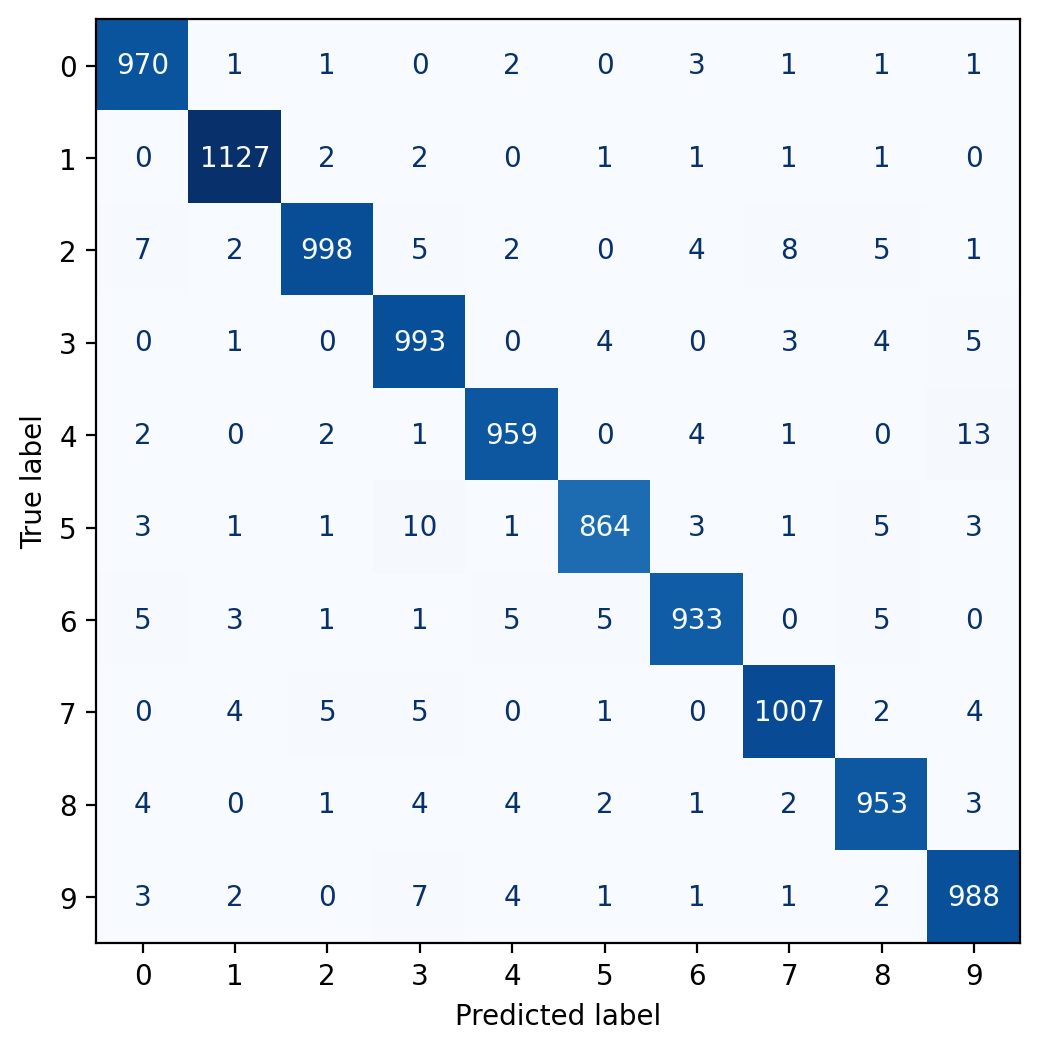

In [14]:
all_preds = [ ]
all_labels = [ ]

model.eval()
with torch.no_grad():
    for x_val, y_val in val_dataloader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_pred = model(x_val)
        preds = torch.argmax(y_pred, dim = -1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap = plt.cm.Blues, ax = ax, colorbar = False)
plt.show()

In [1]:
def show_errors(model, dataloader, device, n_images = 24, cols = 6):

    model.eval()
    images_shown = 0
    rows = int(np.ceil(n_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (16, 8))
    
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            preds = torch.argmax(y_pred, dim = 1)
            
            for i in range(x_batch.size(0)):
                if images_shown >= n_images:
                    break
                if preds[i] != y_batch[i]: 
                    ax = axes.flat[images_shown]
                    ax.imshow(x_batch[i][0].cpu(), cmap = 'gray')
                    ax.set_title(f"Pred: {classes[preds[i].item()]}\nTrue: {classes[y_batch[i].item()]}", color='red')
                    ax.axis('off')
                    images_shown += 1
            if images_shown >= n_images:
                break
    
    plt.tight_layout()
    plt.show()

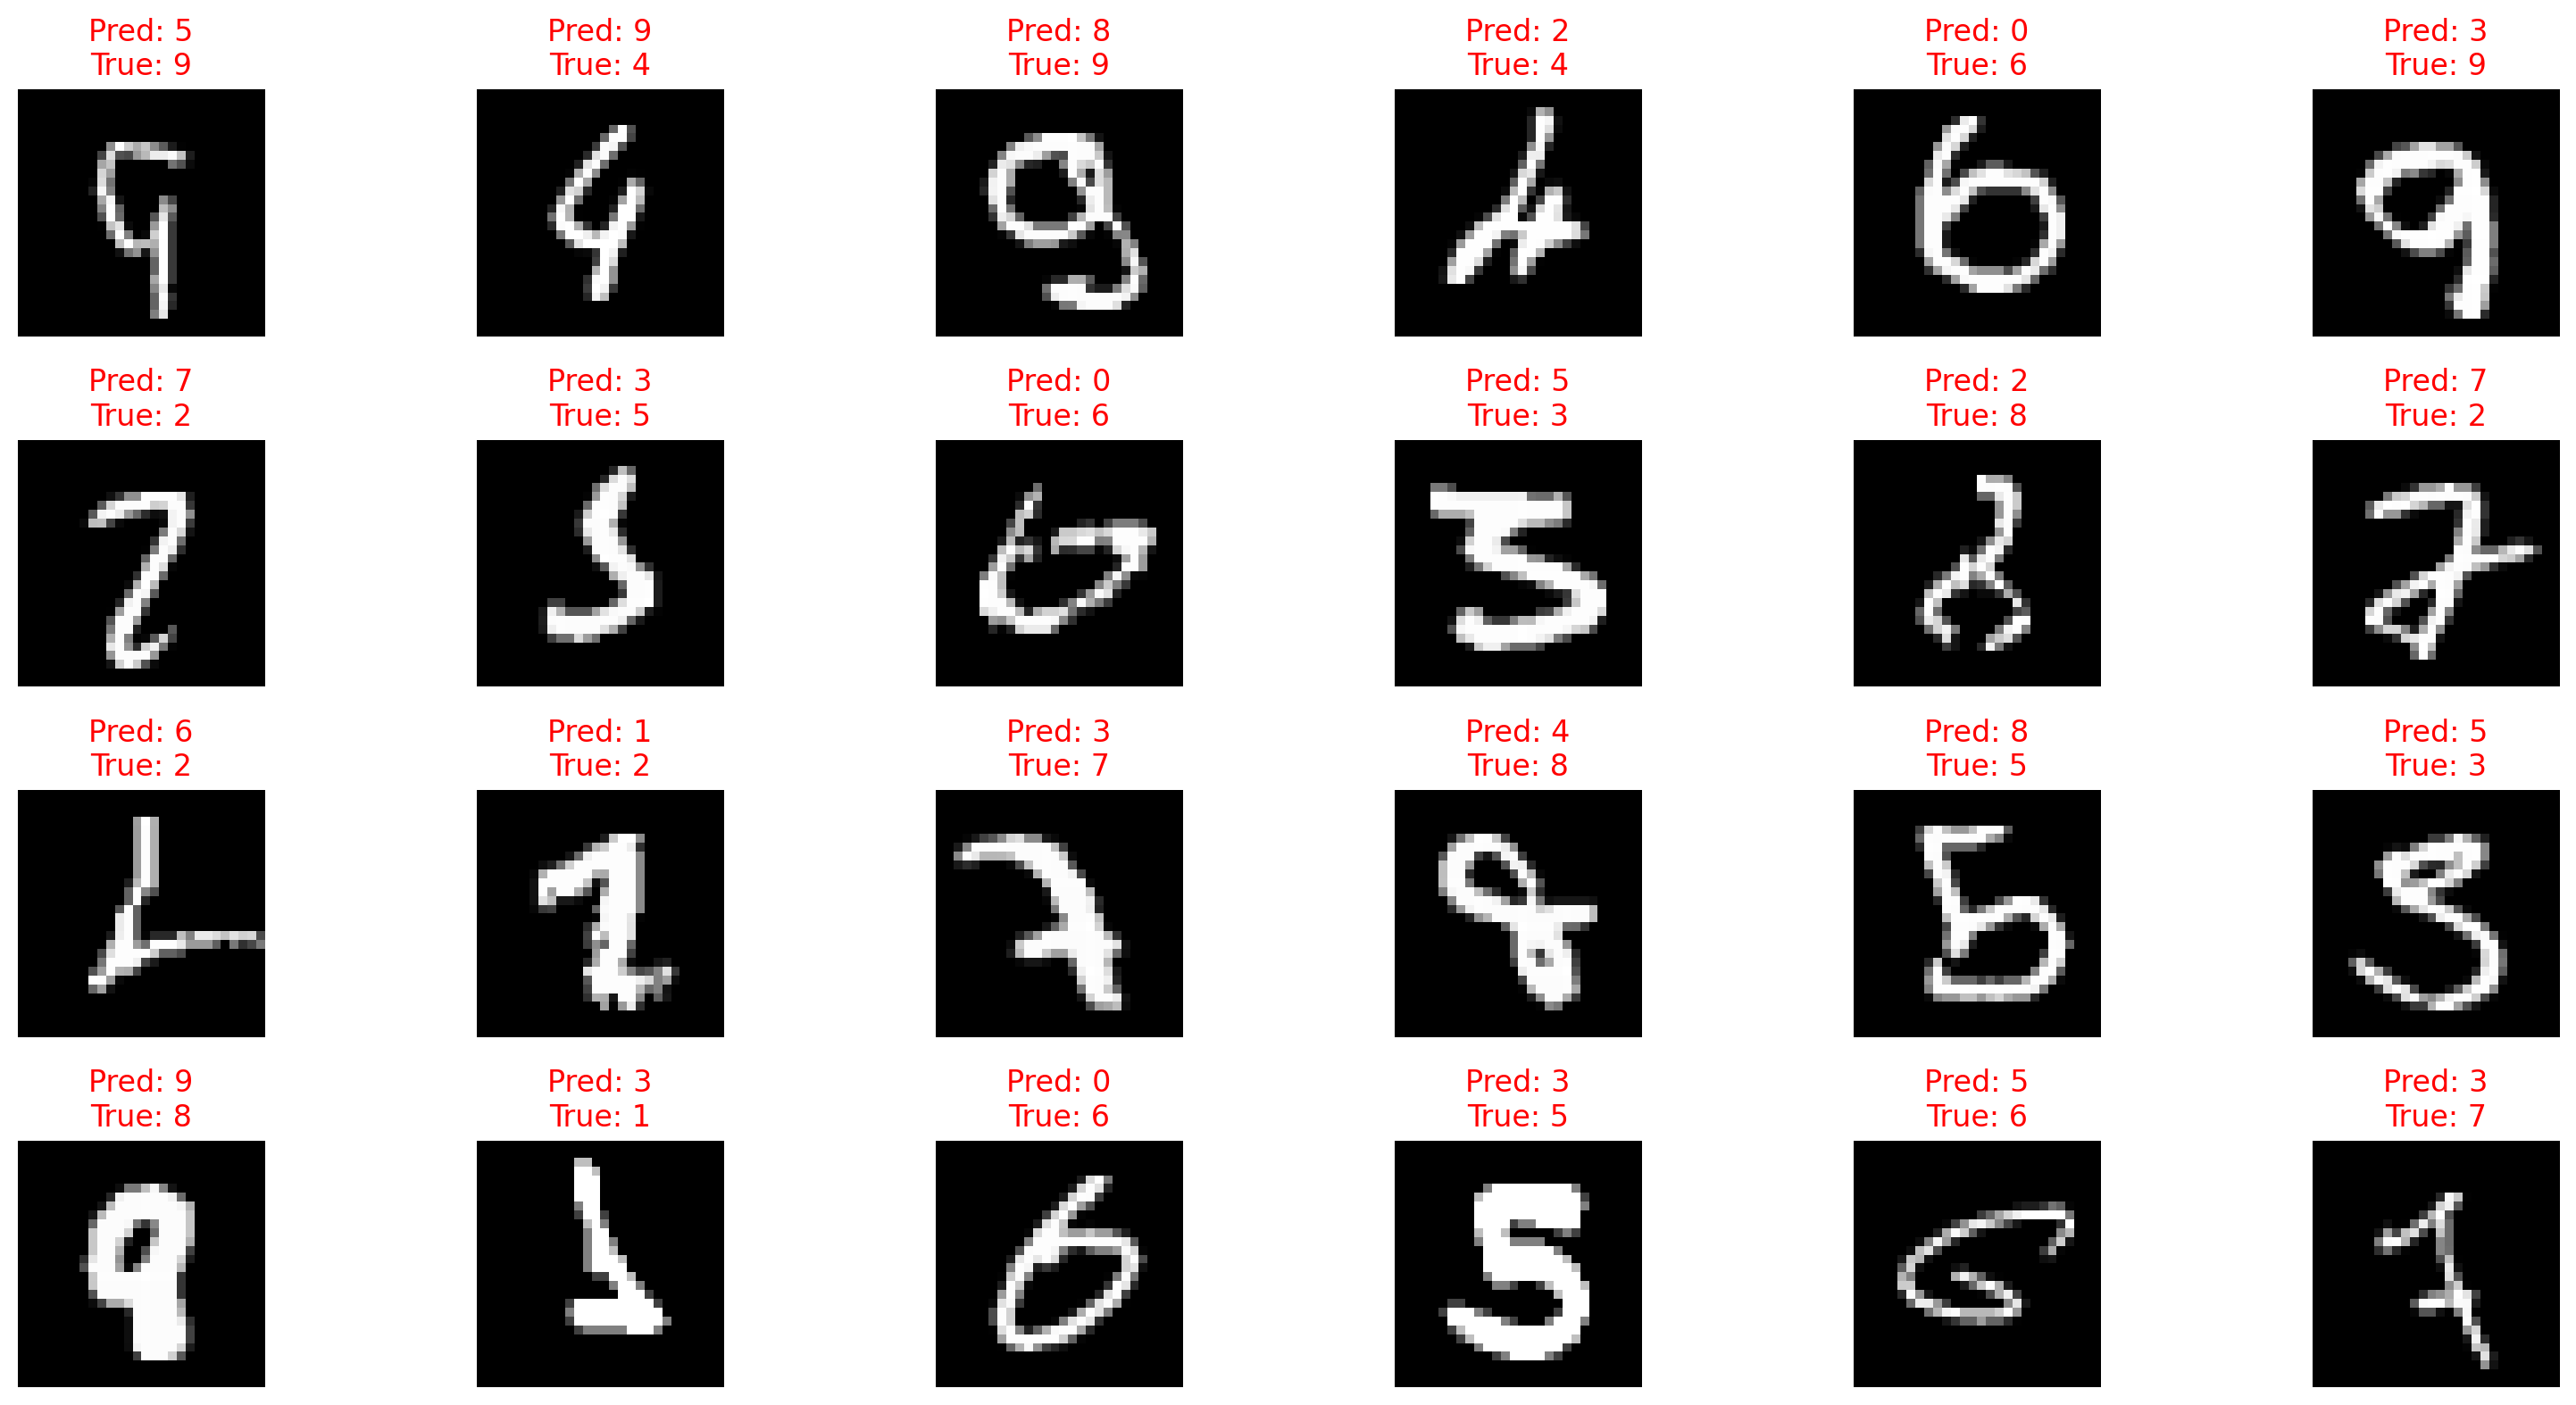

In [16]:
show_errors(model, val_dataloader, device, n_images = 24, cols = 6)

In [17]:
model_conv = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Flatten(),
    nn.Linear(320, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [18]:
optimizer = torch.optim.Adam(model_conv.parameters(), lr = 0.001)

In [19]:
print(f"Training model with {sum([x[1].numel() for x in model_conv.named_parameters()])} parameters")
train(model_conv, train_dataloader, val_dataloader, optimizer, device, epochs = 10)

Training model with 47658 parameters


Epoch 1/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: val_loss=0.0538, val_acc=0.9835


Epoch 2/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: val_loss=0.0473, val_acc=0.9853


Epoch 4/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: val_loss=0.0308, val_acc=0.9906


Epoch 6/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: val_loss=0.0295, val_acc=0.9908


Epoch 8/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1500 [00:00<?, ?it/s]

Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: val_loss=0.0380, val_acc=0.9894


Epoch 10/10:   0%|          | 0/1500 [00:00<?, ?it/s]

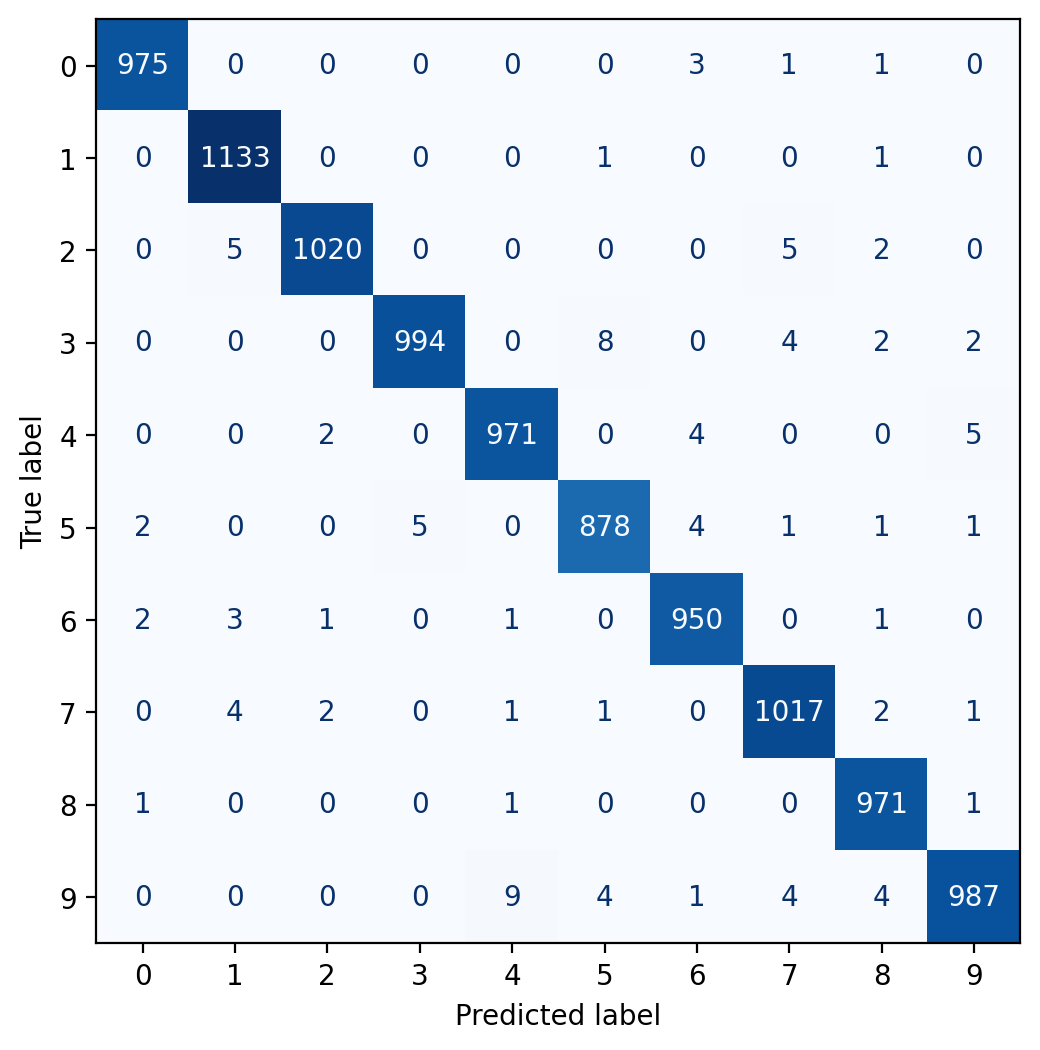

In [20]:
all_preds = [ ]
all_labels = [ ]

model_conv.eval()
with torch.no_grad():
    for x_val, y_val in val_dataloader:
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_pred = model_conv(x_val)
        preds = torch.argmax(y_pred, dim = -1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

fig, ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap = plt.cm.Blues, ax = ax, colorbar = False)
plt.show()

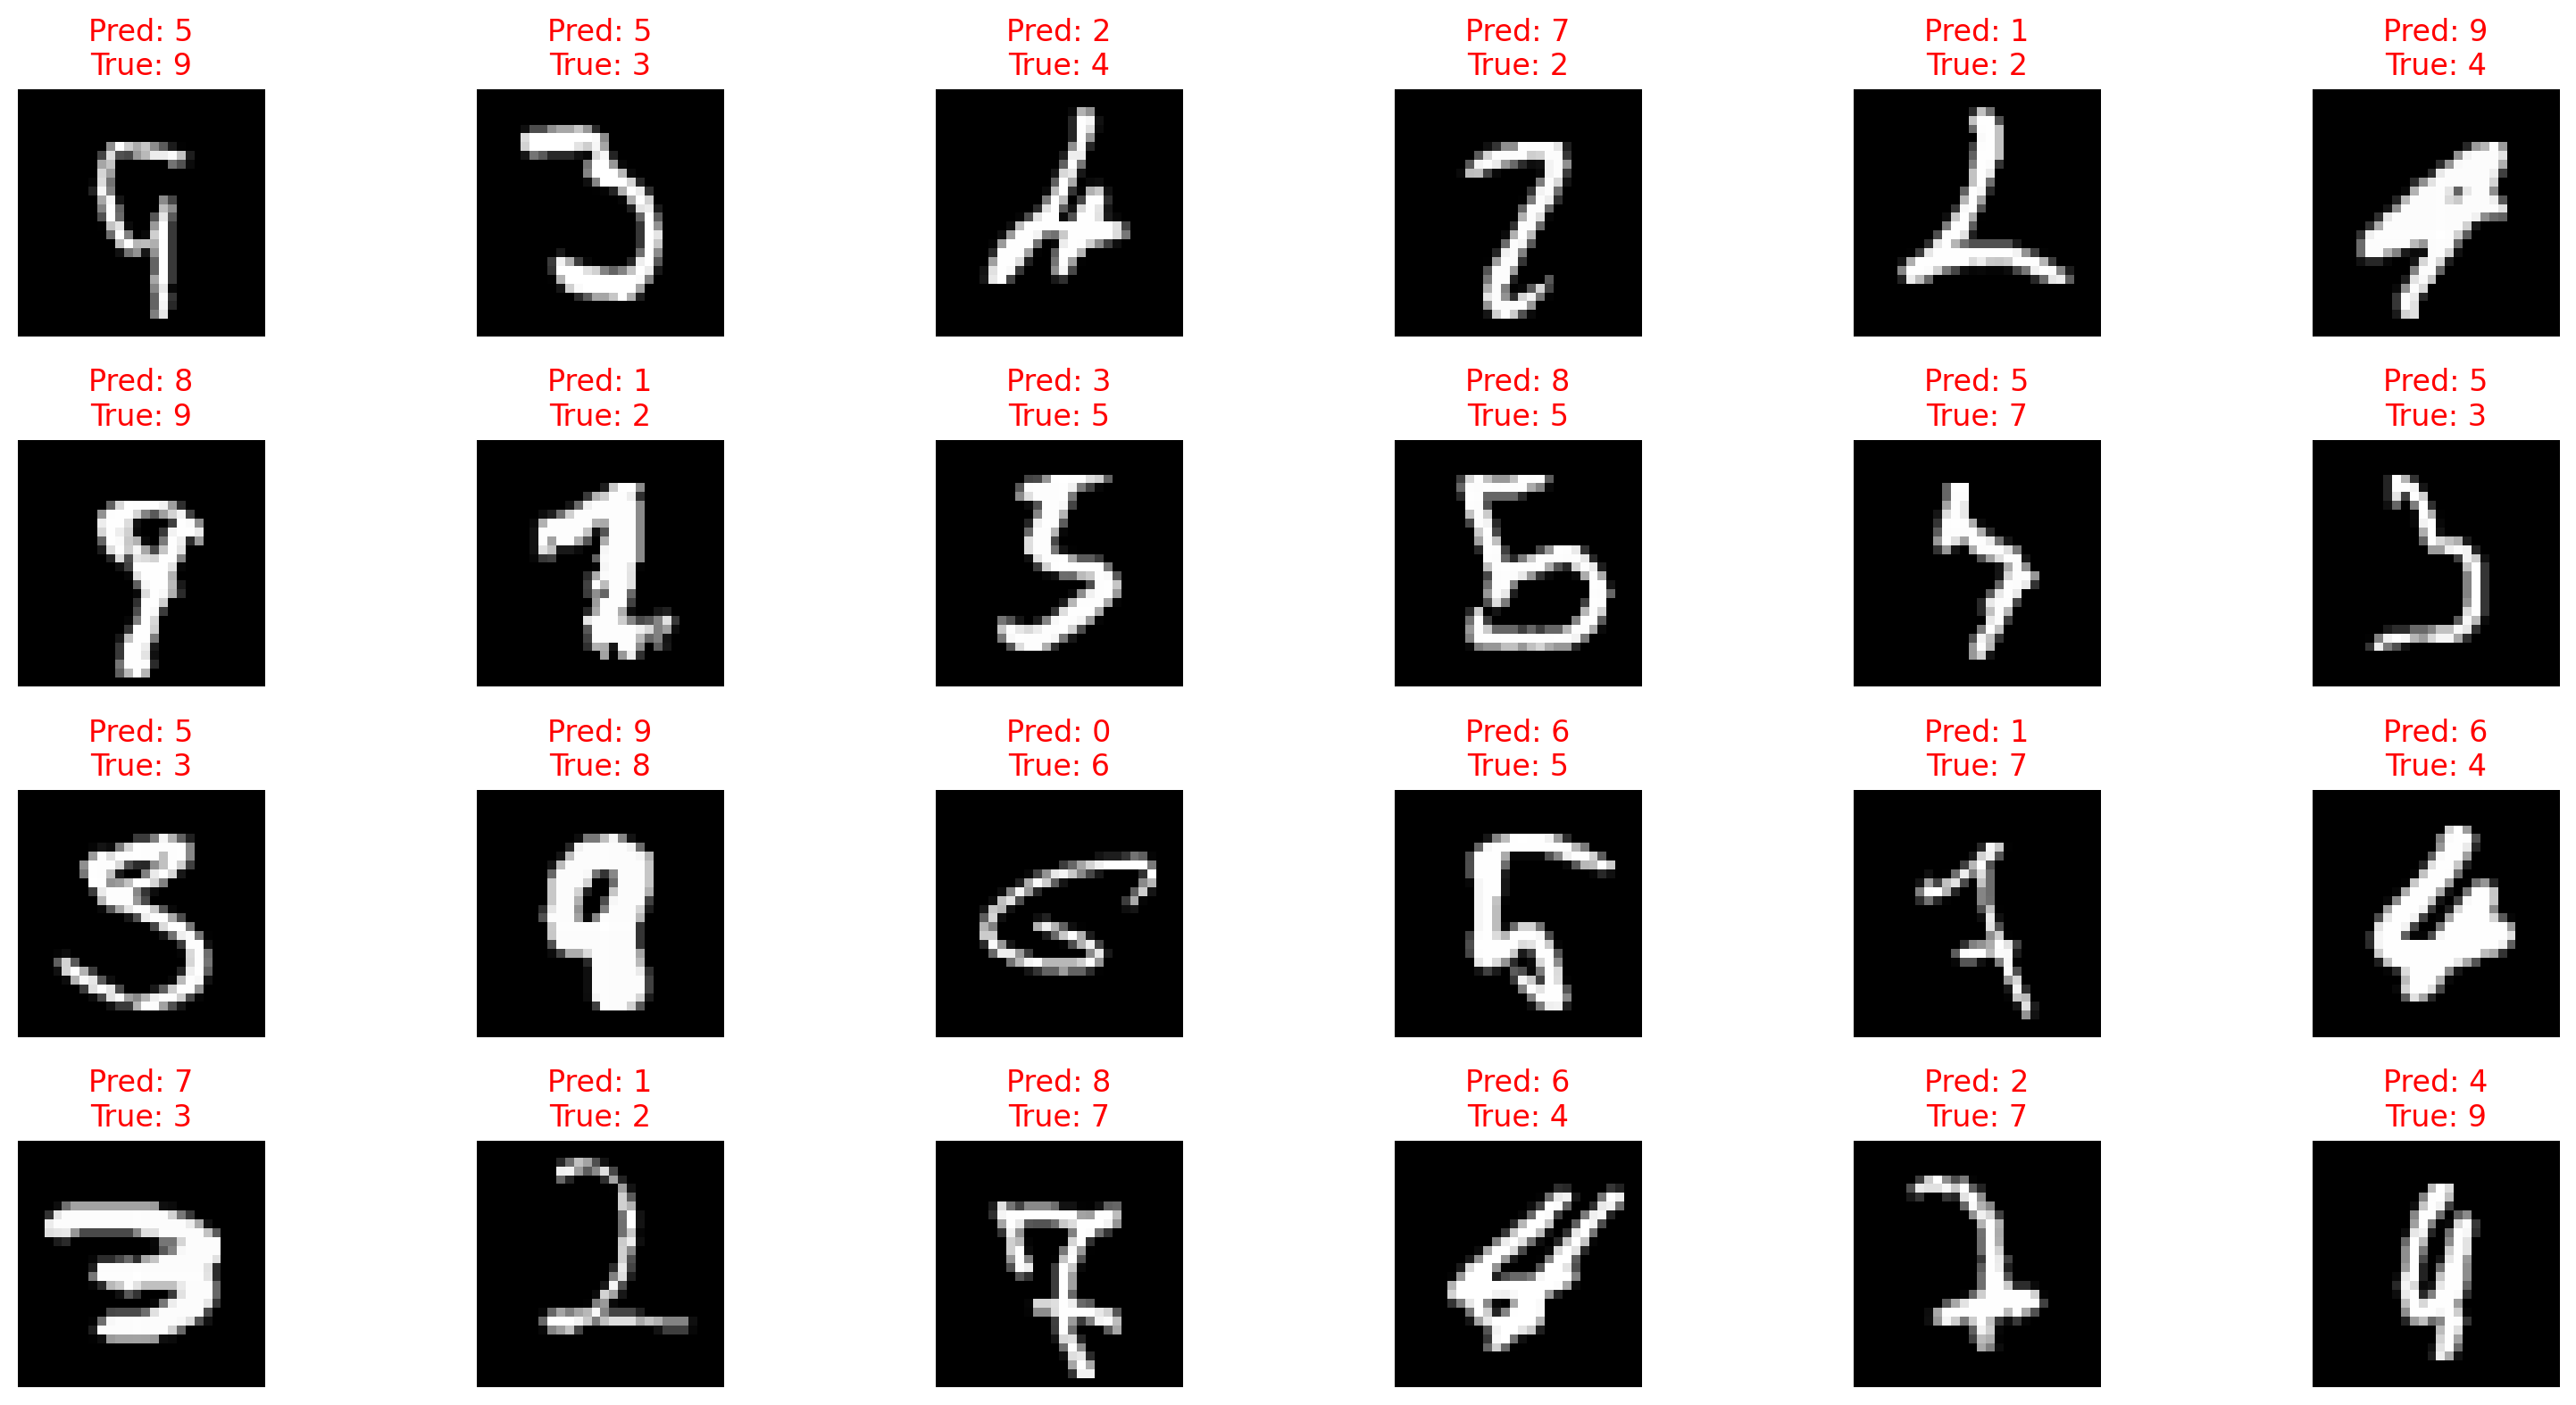

In [21]:
show_errors(model_conv, val_dataloader, device, n_images = 24, cols = 6)